In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 08a

## Working with Tensorflow 
- One hidden layer
- ${Swish}$ activation function
- Adam
- Multi-class output
- Fashion Mist

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [3]:
###-----------------
### Import Libraries
###-----------------

import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay


import tensorflow as tf
from torch.utils.data import Dataset, DataLoader
# from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix, fn_plot_torch_hist

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F



In [5]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models' # location of the images
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
# np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
# tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 26 # number of epochs
ALPHA = 0.001 # learning rate

BATCH_SIZE = 32

TEST_SIZE = 0.2

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [6]:

###----------------------
### Plot confusion matrix
###----------------------
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();

In [7]:

###------------------------------
### Plot Loss Curve using pytorch
###------------------------------
def fn_plot_torch_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset=y2)
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot
        
    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()


## Basic Hygiene

In [8]:
# # Check if all directories are present
# if not os.path.exists(os.path.join(outDir)):
#     os.makedirs(os.path.join(outDir))
#     print ('Created {} directory'.format(outDir))

# if not os.path.exists(os.path.join(modelDir, subDir)):
#     os.makedirs(os.path.join(modelDir, subDir))
#     print ('Created {} directory'.format(os.path.join(modelDir, subDir)))
    

In [9]:
### Settings so that Tensorflow can not Hog all the GPU memory
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Read Fashion Mist 2019 data set

In [10]:
test_df = pd.read_csv(r'D:\DNN\input\fashion_mnist\fashion-mnist_test.csv')
train_df = pd.read_csv(r'D:\DNN\input\fashion_mnist\fashion-mnist_train.csv')

In [11]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
class_labels={
    0:'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle Boot',
}

In [13]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [14]:
class FashionDS(Dataset):

    def __init__(self,
                 dataframe:pd.DataFrame,
                 device:str=device,
                 ):
        
        self.df=dataframe
        self.device=device
        self.labels=self.df['label'].to_numpy()
        
        X=self.df.drop('label',axis=1).to_numpy()

        
        self.features=X/255.
        
    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        features=self.features[index]
        label=self.labels[index]
        
        features=torch.tensor(features,
                              dtype=torch.float32,
                              device=self.device)

        label=torch.tensor(label,
                              dtype=torch.int64,
                              device=self.device)

        return features,label           



In [15]:

train_ds=FashionDS(train_df)
test_ds=FashionDS(test_df)

In [16]:
train_loader=DataLoader(train_ds,
                        batch_size=BATCH_SIZE,
                        shuffle=True
                        )


test_loader=DataLoader(test_ds,
                        batch_size=BATCH_SIZE,
                        shuffle=True
                        )

In [17]:
images, targets= next(iter(train_loader))

images=images.cpu().numpy()
targets=targets.cpu().numpy()
targets

array([6, 4, 5, 6, 1, 4, 6, 0, 6, 5, 7, 2, 5, 6, 1, 6, 4, 1, 4, 0, 9, 4,
       9, 1, 0, 3, 0, 2, 8, 1, 8, 7], dtype=int64)

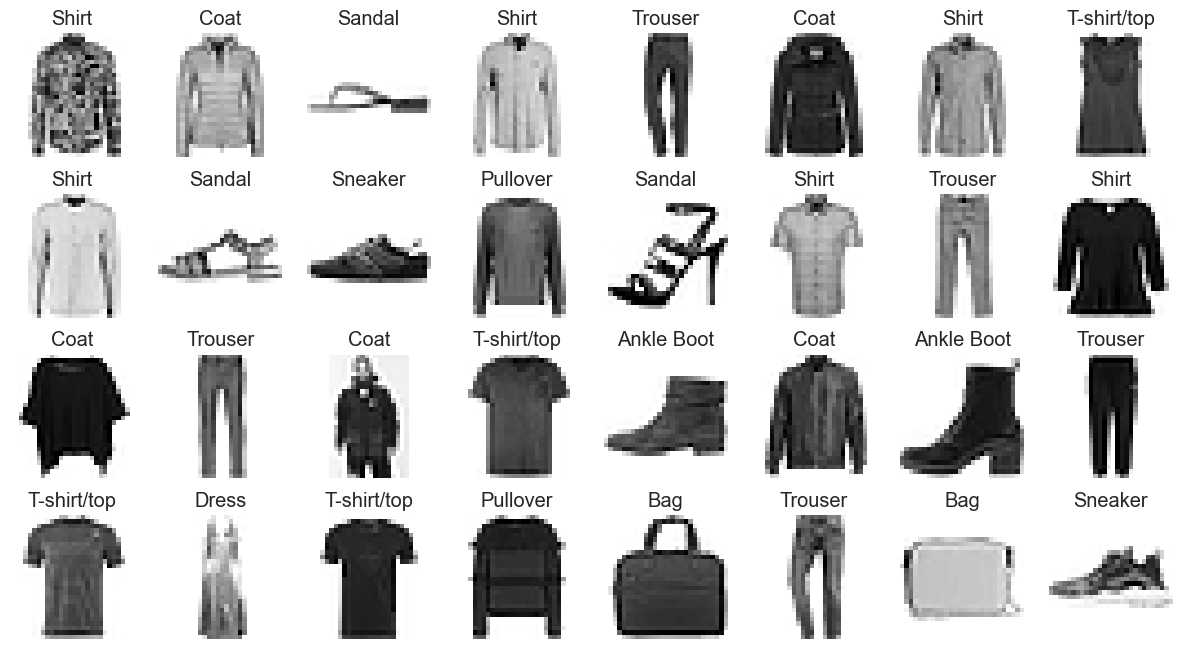

In [18]:
plt.figure(figsize=(15,8))
for i in range(BATCH_SIZE):
    plt.subplot(4,8,i+1)
    plt.imshow(images[i].reshape(28,28),cmap=plt.cm.binary)

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_labels[targets[i]])

In [19]:
input_shape=train_df.shape[1]-1
input_shape

784

In [29]:
class Model(nn.Module):
    def __init__(self,input_dim):
        super(Model,self).__init__()
        self.layer1=nn.Linear(input_dim,128)
        self.activ1=nn.Tanh()
        self.layer2=nn.Linear(128,32)
        self.activ2=nn.Tanh()
        self.layer3=nn.Linear(32,10)
        self.softmax =nn.LogSoftmax(dim=1)

    def forward(self,x):
        x=self.layer1(x) #layer 1 aggregation
        x=self.activ1(x) #layer 1 activation
        x=self.layer2(x) #layer 1 aggregation
        x=self.activ2(x) #layer 1 activation
        x=self.layer3(x) #layer 1 aggregation
        return self.softmax(x)
net = Model(input_dim=input_shape).to(device)
print(net)

Model(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (activ1): Tanh()
  (layer2): Linear(in_features=128, out_features=32, bias=True)
  (activ2): Tanh()
  (layer3): Linear(in_features=32, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [30]:
train_loader=DataLoader(train_ds,
                        batch_size=BATCH_SIZE,
                        shuffle=True
                        )


test_loader=DataLoader(test_ds,
                        batch_size=BATCH_SIZE,
                        shuffle=True
                        )

In [31]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(net.parameters(), lr=ALPHA)

# Train the model for multiple epochs

for epoch in range(EPOCHS):
    
    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for i, data in enumerate(train_loader):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        
        preds = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        
        batch_loss.backward()
        
        optimizer.step()
        
        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)
    
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        
        for data in test_loader:
            
            inputs, labels = data
            
            outputs = net(inputs)
            
            preds = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, labels)

            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            
            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)
        
        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)
    
    if epoch%5 == 0:
        print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')

At epoch 0 | Loss - train:0.5272, test:0.4613 | Acc - train:0.8167, test:0.8356
At epoch 5 | Loss - train:0.2904, test:0.3207 | Acc - train:0.8930, test:0.8829
At epoch 10 | Loss - train:0.2506, test:0.3166 | Acc - train:0.9074, test:0.8861
At epoch 15 | Loss - train:0.2183, test:0.3104 | Acc - train:0.9183, test:0.8907
At epoch 20 | Loss - train:0.1971, test:0.3202 | Acc - train:0.9262, test:0.8888
At epoch 25 | Loss - train:0.1817, test:0.3475 | Acc - train:0.9327, test:0.8827
At epoch 30 | Loss - train:0.1669, test:0.3391 | Acc - train:0.9378, test:0.8914
At epoch 35 | Loss - train:0.1535, test:0.3465 | Acc - train:0.9433, test:0.8931
At epoch 40 | Loss - train:0.1467, test:0.3510 | Acc - train:0.9453, test:0.8925
At epoch 45 | Loss - train:0.1375, test:0.3636 | Acc - train:0.9489, test:0.8926
At epoch 50 | Loss - train:0.1287, test:0.3767 | Acc - train:0.9534, test:0.8888


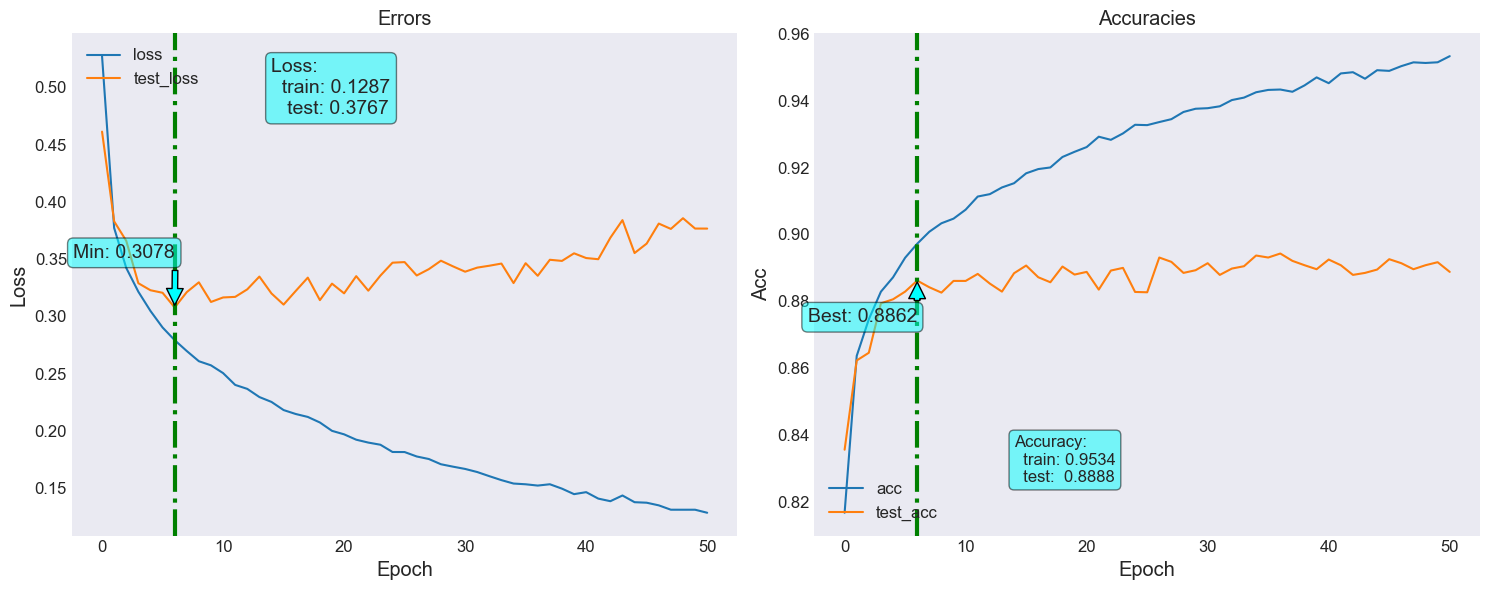

In [32]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                       'loss' : loss,
                       'test_loss' : tloss,
                       'acc' : acc,
                       'test_acc': tacc})

fn_plot_torch_hist(loss_df)

In [33]:
y_train=[]
y_pred=[]
for i ,data in enumerate(train_loader):
    inputs,labels=data
    outputs=net(inputs)
    preds=torch.argmax(outputs,dim=1)
    y_train.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

In [34]:
print(classification_report(y_train, y_pred ))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      6000
           1       1.00      0.99      1.00      6000
           2       0.93      0.88      0.91      6000
           3       0.97      0.96      0.96      6000
           4       0.87      0.93      0.90      6000
           5       1.00      1.00      1.00      6000
           6       0.83      0.92      0.87      6000
           7       0.99      1.00      0.99      6000
           8       1.00      1.00      1.00      6000
           9       1.00      0.99      0.99      6000

    accuracy                           0.95     60000
   macro avg       0.96      0.95      0.95     60000
weighted avg       0.96      0.95      0.95     60000



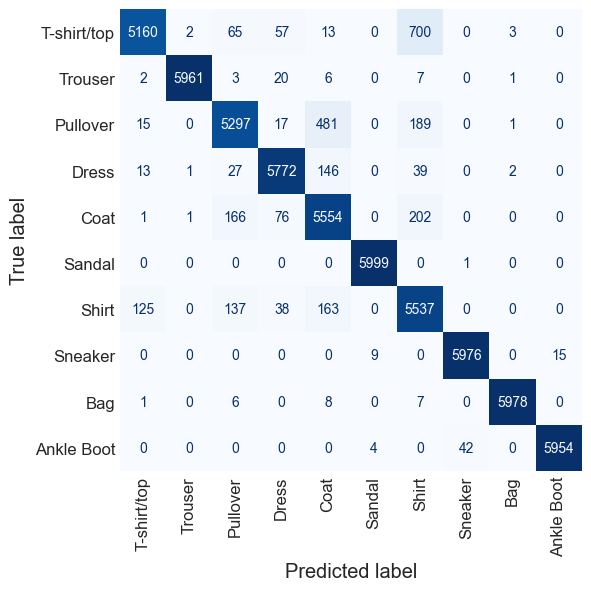

In [35]:
fn_plot_confusion_matrix(y_train, y_pred, labels=class_labels)

In [36]:
images,targets = next(iter(train_loader))
images = images.cpu.numpy()
plt.imshow(images[0].reshape(28,28),cmap=plt.cm.binary)

AttributeError: 'builtin_function_or_method' object has no attribute 'numpy'